# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# Hydrogen Atom

We will start by studying the Hydrogen Atom:

$$
\begin{align*}

H &= -\frac12(\nabla^2_1 + \nabla_2^2) - \frac2{r_1} - \frac2{r_2} + |\textbf r_1 - \textbf r_2|
\\\\


\psi(\textbf r_1, \textbf r_2) &= e^{-\beta r_1}e^{\beta r_2}

\end{align*}
$$

# Metropolis Sampling Position

In [6]:
def rvec(pos: np.ndarray) -> float:
    return np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)


def rxyz(x: float, y: float, z:float) -> float:
    return np.sqrt(x**2 + y**2 + z**2)


def samplePos(M: int, beta: float, delta: float = 0.5) -> tuple[np.ndarray, np.ndarray]:
    """
        Samples M positions taking as the desired distribution psi, assuming psi is real!
    """

    # List of samples
    samples1 = np.zeros((M), dtype=float)
    samples2 = np.zeros((M), dtype=float)
    samplesd = np.zeros((M), dtype=float)

    # Starting position
    x1, y1, z1 = 10, 0.1, 0.01
    x2, y2, z2 = 0.1, 0.2, 0.3
    r1 = rxyz(x1, y1, z1)
    r2 = rxyz(x2, y2, z2)
    dr = rxyz(x1-x2, y1-y2, z1-z2)

    samples1[0] = r1
    samples2[0] = r2
    samplesd[0] = dr

    logpsi = -beta * (r1 + r2)

    # Metropolis Loop
    succ = 0
    for attempt in range(M-1):
        # Moves for electron 1
        xp1 = x1 + delta*(np.random.random() - 0.5)
        yp1 = y1 + delta*(np.random.random() - 0.5)
        zp1 = z1 + delta*(np.random.random() - 0.5)
        
        # Moves for electron 2
        xp2 = x2 + delta*(np.random.random() - 0.5)
        yp2 = y2 + delta*(np.random.random() - 0.5)
        zp2 = z2 + delta*(np.random.random() - 0.5)

        rp1 = rxyz(xp1, yp1, zp1)
        rp2 = rxyz(xp2, yp2, zp2)
        logpsip = -beta * (rp1 + rp2)

        accept = min(1, np.exp(2 * (logpsip - logpsi)))

        # Metropolis question
        if accept > np.random.random():
            succ += 1

            x1, y1, z1 = xp1, yp1, zp1
            r1 = rp1
            
            x2, y2, z2 = xp2, yp2, zp2
            r2 = rp2

            logpsi = logpsip
            dr = rxyz(xp1-xp2, yp1-yp2, zp1-zp2)
        
        # Save state
        samples1[attempt+1] = r1
        samples2[attempt+1] = r2
        samplesd[attempt+1] = dr
    
    print(f"Acceptance: {succ / attempt}")
    return (samples1, samples2, samplesd)

In [7]:
def sampleNeff(data: np.ndarray, k1: int = 0, icutoff: int = 200) -> int:
    # Raw data
    N = len(data)
    k2 = N-1

    # icutoff = int(k2 * icutoff)
    Neq = k2 - k1 + 1

    # Calculate Stats
    ave = np.mean(data)
    var = np.var(data, mean=ave, ddof=1)

    autocorr = np.array([np.sum((data[k1: k2-i]-ave) * (data[k1 + i: k2]-ave)) / (Neq - i) for i in range(1, Neq)]) / (var)
    timecorr = 1 + 2 * np.sum(autocorr[:icutoff] * (autocorr[:icutoff] > 0))

    Neff = Neq / timecorr
    print(f"Neff: {Neff}")

    return Neff

## No Reweighting

Beta = 1.000
Acceptance: 0.8723829843979197
Neff: 256.7047792890791
Energy = -2.2736148508020495
Variance on Energy = 1.4425044474798792
Standard Deviation on Mean Energy = 0.07496207562547182

Beta = 1.100
Acceptance: 0.8602480330710761
Neff: 295.96917476096326
Energy = -2.4222713020747006
Variance on Energy = 1.4792236115113466
Standard Deviation on Mean Energy = 0.07069580994354387

Beta = 1.200
Acceptance: 0.8390452060274703
Neff: 404.8642244776138
Energy = -2.589586552151107
Variance on Energy = 1.7080372969278768
Standard Deviation on Mean Energy = 0.06495221615691013

Beta = 1.300
Acceptance: 0.8259767969062541
Neff: 471.11069724151827
Energy = -2.7581359305622053
Variance on Energy = 1.4663917804753668
Standard Deviation on Mean Energy = 0.05579092037923731

Beta = 1.400
Acceptance: 0.8167088945192692
Neff: 354.98000819025106
Energy = -2.6923694321297322
Variance on Energy = 1.023260653887007
Standard Deviation on Mean Energy = 0.05368972629743262

Beta = 1.500
Acceptance: 0.81

Text(0.5, 1.0, 'Parameter Sweep')

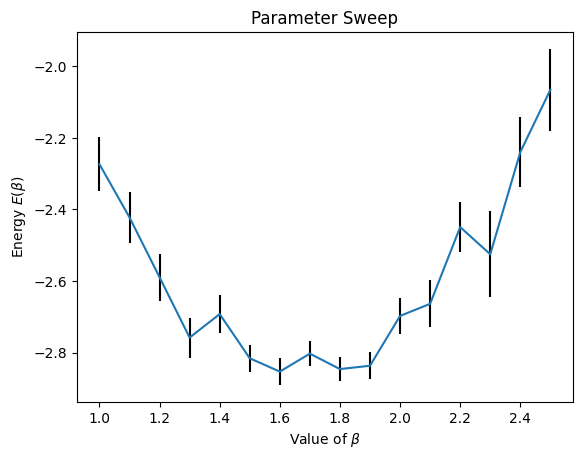

In [16]:
# Parameters
sampleM = 15000
discard = 1500
delta = 0.4

# Sweep Variational Parameter
betaMin = 1
betaMax = 2.5

Ebeta = []
Estd = []
Evar = []
bbRange = np.linspace(betaMin, betaMax, 16)
for betaStart in bbRange:
    print(f"Beta = {betaStart:.3f}")
    Rs1, Rs2, Rsd = samplePos(sampleM, betaStart, delta)
    Rs1, Rs2, Rsd = Rs1[discard:], Rs2[discard:], Rsd[discard:]
    El = -betaStart**2 + betaStart * (1/Rs1 + 1/Rs2) - (2/Rs1 + 2/Rs2) + 1/Rsd
    Neff = sampleNeff(El)

    Evar += [np.var(El)]
    Estd += [np.std(El) / np.sqrt(Neff)]
    Ebeta += [np.average(El)]
    print(f"Energy = {Ebeta[-1]}")
    print(f"Variance on Energy = {Evar[-1]}")
    print(f"Standard Deviation on Mean Energy = {Estd[-1]}")
    print("")

print(f"Best beta: {bbRange[Ebeta.index(np.min(Ebeta))]}")
plt.errorbar(bbRange, Ebeta, yerr=Estd, ecolor="black")
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")

# With Reweighting

BetaMid = 2.000
Acceptance: 0.4424070678446408
Neff: 97.8709269755538

BetaMid = 1.200
Acceptance: 0.6406067677946324
Neff: 56.8587104060198

BetaMid = 1.000
Acceptance: 0.6873645607601266
Neff: 58.69275043606623

BetaMid = 1.000
Acceptance: 0.7046174362393732
Neff: 47.23528125048263

BetaMid = 1.000
Acceptance: 0.6832805467577929
Neff: 66.13826869977365

Final beta: 1.0
Minimum energy: -0.5


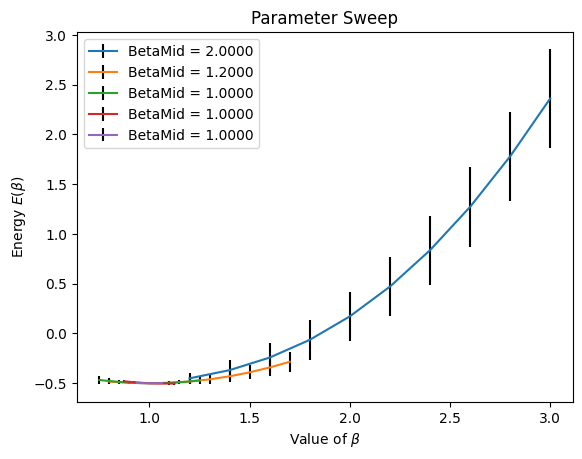

In [5]:
# Sampling Parameters
sampleM = 12000
discard = 2000

delta = 1.4

# Target Function is energy + stdW * std
stdW = 2

# Starting Variational Parameters
betaStart = 2

betaRange = 1
betaSamples = 21
betaMult = 1

betaSteps = 5

betaMid = betaStart
for _ in range(betaSteps):
    betaMin = betaMid - betaRange
    betaMax = betaMid + betaRange

    Ebeta = []
    Estd = []
    bb = []
    bbRange = np.linspace(betaMin, betaMax, betaSamples)
    
    print(f"BetaMid = {betaMid:.3f}")
    Rs = samplePos(sampleM, betaMid, delta=delta)
    Rs = Rs[discard:]
    Neff = sampleNeff(Rs)
    for beta in bbRange:
        # Calculate weights
        ww = np.exp(-2 * (beta - betaMid) * Rs)

        # Effective number of points
        m = ((np.sum(ww))**2 / np.sum(ww**2)) / len(Rs)
        if m < 0.5:
            continue

        bb += [beta]

        El = -0.5*beta*(beta - 2/Rs) - 1.0 / Rs
        Estd += [np.std(El) / np.sqrt(Neff)]
        Ebeta += [(np.sum(El * ww)) / (np.sum(ww))]
    
    # Plot results
    plt.errorbar(bb, Ebeta, yerr=Estd, ecolor="black", label=f"BetaMid = {betaMid:.4f}")
    
    # Target function
    target = [Ebeta[i] + stdW * Estd[i] for i in range(len(bb))]

    betaMini = bb[target.index(min(target))]
    betaMid = betaMini
    betaRange *= betaMult
    print("")


print(f"Final beta: {betaMini}")
print(f"Minimum energy: {min(Ebeta)}")

plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")
plt.legend()